# Use case: glass in periodic boundary conditions

Monte-Carlo simulation data of a polydisperse hard sphere glass. Courtesy of John Russo.

The simulation box is cubic of period 203 and all particle coordinates are in [0,203).

In [1]:
import numpy as np
from scipy.spatial import cKDTree as KDTree
import boo
#from boo import boo
from matplotlib import pyplot as plt
from matplotlib import ticker
%matplotlib inline

## Prepare input

load coordinates

In [2]:
L = 203.
xyzr = np.loadtxt('3d_6_0.54_0.dat')
radius = xyzr[:,-1]
pos = xyzr[:,:-1]
pos.shape, pos.max()

((16384, 3), 202.999)

Radius probability distribution function

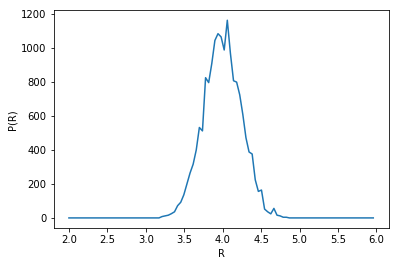

In [3]:
plt.plot(np.linspace(2,6,100)[:-1], np.histogram(radius, np.linspace(2,6,100))[0])
plt.xlabel('R')
plt.ylabel('P(R)')

Display a thin slice 

*This is really a quick but dirtyc way of showing the data in real space. Do not use this for a publication.*

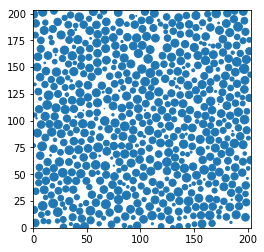

In [4]:
z0 = 100
sl = (pos[:,-1] > z0 - radius) & (pos[:,-1] < z0 + radius)
markersize = 4*(radius[sl]**2 - (pos[sl,-1]-z0)**2)
plt.scatter(pos[sl,0], pos[sl,1], s=markersize, marker='o')

plt.xlim(0,L)
plt.ylim(0,L)
plt.axes().set_aspect('equal', 'box')

### Construct the neighbour lists. 
People doing simulations probably have neighbour lists they can tuncate with various criteria. Here, let us say that this data was lost or not saved. Because of periodic boundary conditions we cannot use directly KDTree or Delaunay triangulations from `scipy.spatial`. It is always possible to compute the whole $N(N-1)$ distances by brute force (don't do this at home).

In [5]:
from numba import jit
from math import floor
@jit(nopython=True) #numba to speed up our brute force approach
def periodic_neighbours(pos, maxdist, L):
    maxdistsq = maxdist**2
    rL = 1./L
    bonds = []
    dists = []
    for i in range(len(pos)-1):
        for j in range(i+1, len(pos)):
            distsq = 0
            for d in range(pos.shape[1]):
                diff = pos[i,d] - pos[j,d]
                diff -= L * floor(diff * rL + 0.5)
                distsq += diff*diff
            if distsq < maxdistsq:
                bonds.append(i)
                bonds.append(j)
                dists.append(distsq)
    return np.array(bonds, np.int64).reshape((len(dists),2)), np.sqrt(np.array(dists, np.float64))
            

In [6]:
maxbondlength = 15.
bonds, dists = periodic_neighbours(pos, maxbondlength, L)

We took a rather lax maximum bond length because we have polydisperse particles. Let us look at the distribution of lengths, scaled like a pair distribution function (note that we have twice as many pairs than bidirectional bonds).

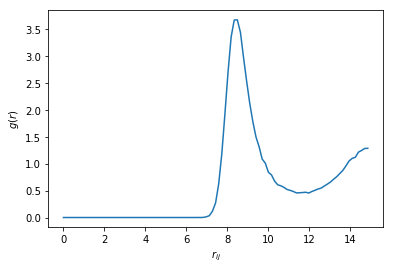

In [7]:
rij_bins = np.linspace(0,maxbondlength,100)
density = len(pos)/L**3
plt.plot(
    rij_bins[:-1], 
    np.histogram(dists, rij_bins)[0] * 2 / (4*np.pi/3 * np.diff(rij_bins**3)) / density / len(pos)
)
plt.xlabel('$r_{ij}$')
plt.ylabel('$g(r)$')

Our maximum bond length is well past the first minimum of $g(r)$. We will keep the first 12 neighbours of each particles, since in a dense 3D hard spheres assembly ordered neighbourhoods (FCC, HCP, icosahedron) should have 12 neighbours.

In [8]:
@jit(nopython=True) #numba to speed up our brute force approach
def bonds2ngbs(bonds, dists, N, Nngb=12):
    """Convert from bonds to neighbour array (at most Nngb neighbours)"""
    ngbs = np.full((N, Nngb), -1, np.int64)
    nngbs = np.zeros(N, np.int64)
    #sort bonds by increasing length to be able to use first-in-first-served
    sbonds = bonds[np.argsort(dists)]
    for i in range(len(sbonds)):
        a = sbonds[i,0]
        b = sbonds[i,1]
        if nngbs[a]< ngbs.shape[1]:
            ngbs[a, nngbs[a]] = b
            nngbs[a] += 1
        if nngbs[b]< ngbs.shape[1]:
            ngbs[b, nngbs[b]] = a
            nngbs[b] += 1
    return ngbs

In [9]:
ngbs = bonds2ngbs(bonds, dists, len(pos))

In [10]:
np.sum(ngbs<0), np.sum(ngbs>=len(pos))

(0, 0)

Alternatively, an equivalent criteria can be taken by considering the distances between particles surfaces rathen than between centers. But it is really cheating with respect to experiments. Let us do this.

In [11]:
drij = dists - (radius[bonds[:,0]] + radius[bonds[:,1]])
ngbs = bonds2ngbs(bonds, drij, len(pos))

## Tensorial bond orientational order

We focus on 6-fold and 4-fold orientational order. We obtain them from the lists of 12 neighbours. Note that we input the size of the box as argument to allow periodic boundary conditions

In [12]:
q6m = boo.ngbs2qlm(pos, ngbs, l=6, periods=L)
q4m = boo.ngbs2qlm(pos, ngbs, l=4, periods=L)

These can be coarse grained. Here there is no wall so all particles are "inside".

In [13]:
inside = np.ones(len(pos), bool)
Q6m, inside2 = boo.coarsegrain_qlm(q6m, bonds, inside)
Q4m, inside2 = boo.coarsegrain_qlm(q4m, bonds, inside)

## Crystals

We identify crystal particles as having at least 7 crystalline bonds (default value)

In [14]:
xpos = boo.x_ngbs(q6m, ngbs).sum(-1) > 6
xpos.sum()

22

We can lower the threshold in the number of crystalline bonds to catch the surface of the crystal

In [15]:
surf = (boo.x_ngbs(q6m, ngbs).sum(-1) > 2) & np.bitwise_not(xpos)
surf.sum()

748

Display a thin slice with colors that depend on the local structure around each particle

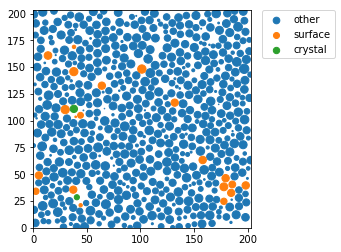

In [16]:
z0 = 100
sl = (pos[:,-1] > z0 - radius) & (pos[:,-1] < z0 + radius)
markersize = 4*np.maximum(0, (radius**2 - (pos[:,-1]-z0)**2))
for label, subset in zip(['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.scatter(pos[sl&subset,0], pos[sl&subset,1], s=markersize[sl&subset], marker='o', label=label)

plt.xlim(0,L)
plt.ylim(0,L)
plt.axes().set_aspect('equal', 'box')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Rotational invarients

Rotational invarients give more precise information about the type of structures. However a sigle quantity if often not enough. That is why we often plot 2D maps.

In [17]:
q6 = boo.ql(q6m)
q4 = boo.ql(q4m)

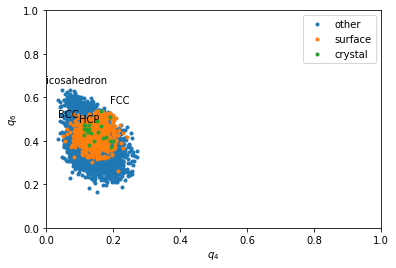

In [18]:
for label, subset in zip(['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.plot(q4[inside&subset], q6[inside&subset], '.', label=label)
plt.xlabel('$q_4$')
plt.ylabel('$q_6$')
plt.xlim(0,1)
plt.ylim(0,1)
plt.text(0.1909, 0.5745, 'FCC')
plt.text(0.0972, 0.4848, 'HCP')
plt.text(0.0364, 0.5107, 'BCC')
plt.text(0, 0.6633, 'icosahedron')
plt.legend()

/home/mathieu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


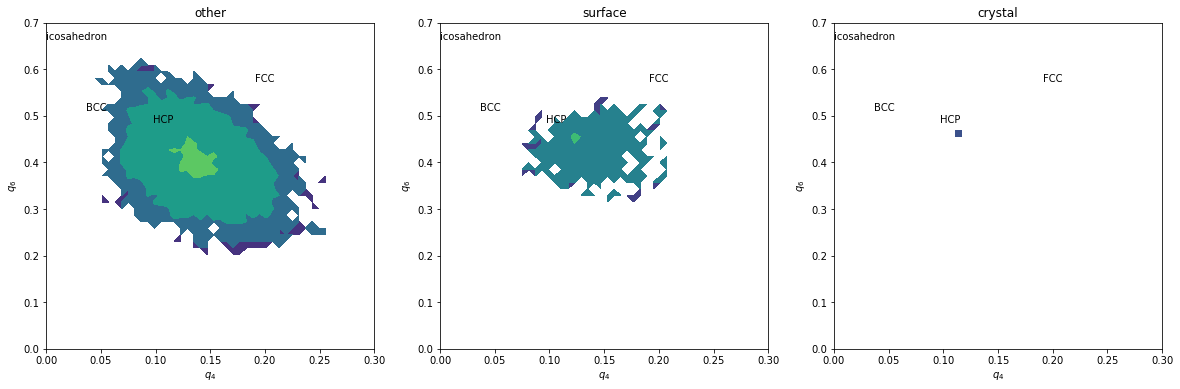

In [29]:
plt.figure(figsize=(20,6))
for i, label, subset in zip(range(3), ['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.subplot(1,3,i+1)
    H, xedges, yedges = np.histogram2d(q6[inside&subset], q4[inside&subset], range=[[0,0.7], [0.,0.3]], bins=(50, 50))
    plt.contourf(H, locator=ticker.LogLocator(), origin='lower', extent=(0,0.3,0,0.7))
    plt.title(label)
    plt.xlabel('$q_4$')
    plt.ylabel('$q_6$')
    plt.xlim(0,0.3)
    plt.ylim(0,0.7)
    plt.text(0.1909, 0.5745, 'FCC')
    plt.text(0.0972, 0.4848, 'HCP')
    plt.text(0.0364, 0.5107, 'BCC')
    plt.text(0, 0.6633, 'icosahedron')

Without coarse graining, data is too noisy, even if the above maps could be refined by summing many time steps.

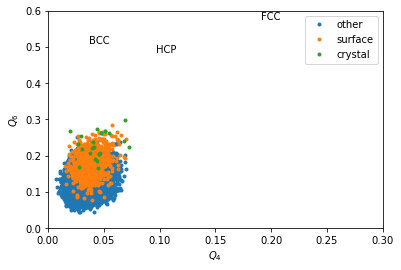

In [20]:
Q6 = boo.ql(Q6m)
Q4 = boo.ql(Q4m)
for label, subset in zip(['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.plot(Q4[inside&subset], Q6[inside&subset], '.', label=label)

plt.xlabel('$Q_4$')
plt.ylabel('$Q_6$')
plt.xlim(0,0.3)
plt.ylim(0,0.6)
plt.text(0.1909, 0.5745, 'FCC')
plt.text(0.0972, 0.4848, 'HCP')
plt.text(0.0364, 0.5107, 'BCC')
plt.legend()

/home/mathieu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


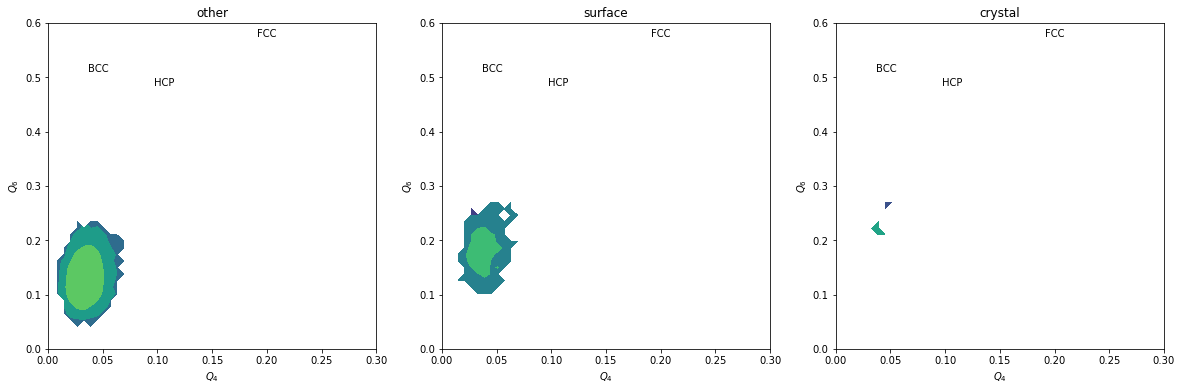

In [21]:
plt.figure(figsize=(20,6))
for i, label, subset in zip(range(3), ['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.subplot(1,3,i+1)
    H, xedges, yedges = np.histogram2d(Q6[inside&subset], Q4[inside&subset], range=[[0, 0.6], [0., 0.3]], bins=(50, 50))
    plt.contourf(H, locator=ticker.LogLocator(), origin='lower', extent=(0, 0.3, 0, 0.6))
    plt.title(label)
    plt.xlabel('$Q_4$')
    plt.ylabel('$Q_6$')
    plt.xlim(0,0.3)
    plt.ylim(0,0.6)
    plt.text(0.1909, 0.5745, 'FCC')
    plt.text(0.0972, 0.4848, 'HCP')
    plt.text(0.0364, 0.5107, 'BCC')

We can completely exclude BCC. Our crystals are a mixture of FCC and HCP.

Coarse graining basically erases the signal from icosahedral structures. $w_6$ makes icosahedron pop out as very negative values.

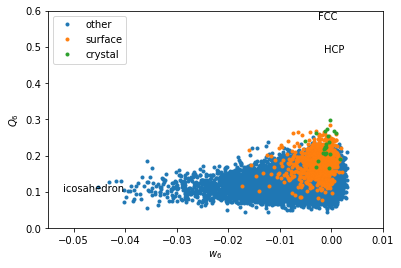

In [22]:
w6 = boo.wl(q6m)
for label, subset in zip(['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.plot(w6[inside2&subset], Q6[inside2&subset], '.', label=label)

plt.xlabel('$w_6$')
plt.ylabel('$Q_6$')
plt.xlim(-0.055, 0.01)
plt.ylim(0,0.6)
plt.text(-0.002626, 0.5745, 'FCC')
plt.text(-0.00149, 0.4848, 'HCP')
plt.text(-0.05213, 0.1, 'icosahedron')
plt.legend(loc='upper left')

/home/mathieu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


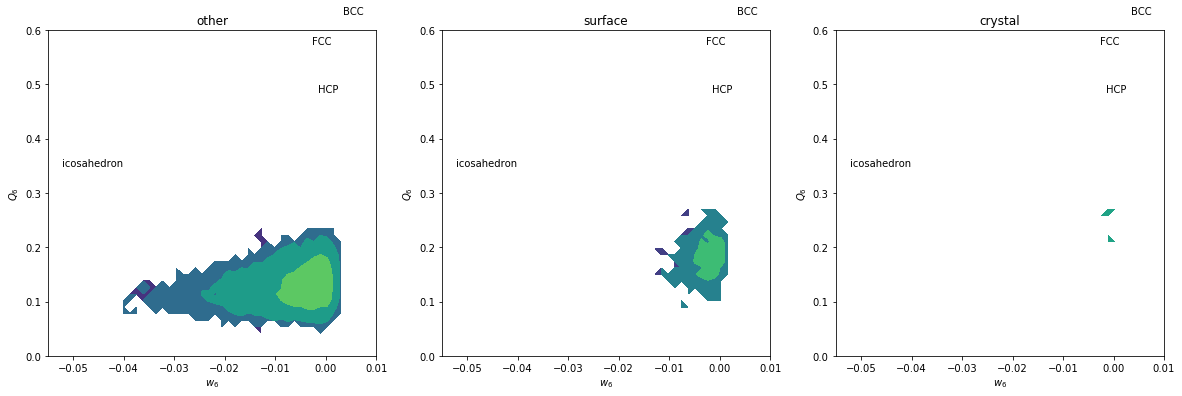

In [23]:
plt.figure(figsize=(20,6))
for i, label, subset in zip(range(3), ['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.subplot(1,3,i+1)
    H, xedges, yedges = np.histogram2d(Q6[inside&subset], w6[inside&subset], range=[[0, 0.6], [-0.055, 0.01]], bins=(50, 50))
    plt.contourf(H, locator=ticker.LogLocator(), origin='lower', extent=(-0.055, 0.01, 0, 0.6))
    plt.title(label)
    plt.xlabel('$w_6$')
    plt.ylabel('$Q_6$')
    plt.xlim(-0.055, 0.01)
    plt.ylim(0,0.6)
    plt.text(-0.002626, 0.5745, 'FCC')
    plt.text(-0.00149, 0.4848, 'HCP')
    plt.text(0.0034, 0.6285, 'BCC')
    plt.text(-0.05213, 0.35, 'icosahedron')

Icosahedral order seems to be dominant here.

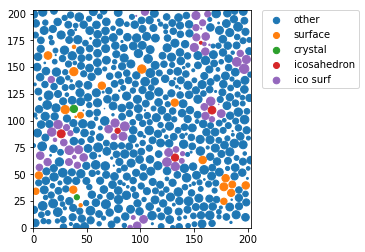

In [24]:
ico = w6 < -0.028
icon = np.zeros(len(pos), bool)
icon[ngbs[ico].ravel()] = True
icon[ico] = False
z0 = 100
sl = (pos[:,-1] > z0 - radius) & (pos[:,-1] < z0 + radius)
markersize = 4*np.maximum(0, (radius**2 - (pos[:,-1]-z0)**2))
for label, subset in zip(
    ['other', 'surface', 'crystal', 'icosahedron', "ico surf"], 
    [np.bitwise_not(xpos|surf|ico|icon), surf, xpos, ico, icon]
):
    plt.scatter(pos[sl&subset,0], pos[sl&subset,1], s=markersize[sl&subset], marker='o', label=label)

plt.xlim(0,L)
plt.ylim(0,L)
plt.axes().set_aspect('equal', 'box')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Spatial correlation

Not implemented in periodic boundary conditions. Using Fourier space should be much faster.

To average the results on different frames, it is better to sum the outputs of `gG_l` and perform the divisions at the end.